# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.preprocessing import filtering as filt
from resurfemg.postprocessing import features as feat
from resurfemg.preprocessing import ecg_removal as ecg_rm
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the sEMG data

In [3]:
config = Config()

base_path = config.get_directory('root_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    extension_regex='poly5',
    folder_levels=None)

In [4]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('4_ontslag_20230421_132716.Data8Raw.Poly5', '4_o…

In [5]:
# Load the EMG  data recordings from the selected folders.
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
n_ch = 4
# Define the time series of the EMG recording
y_emg = data_emg_samples[:n_ch,:]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

Reading file  M:\Documents\CRPH\Cooperations\UMCG_USIsala\UNDATED_sEMGpt4en5\4_ontslag_20230421_132716.Data8Raw.Poly5
	 Number of samples:  445185 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.


In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Intercost','Dia R','Dia L', 'Abd'],
    units=n_ch*['uV'])

No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.


# 3. Pre-process the data

In [7]:
# Filter
emg_timeseries.run('filter_emg', lp_cf=200)

In [8]:
# set ecg channel to channel 0
emg_timeseries.set_ecg_idx(0)
# apply gating according to QRS peaks in ECG channel
emg_timeseries.run('gating',
    gate_width_samples=fs_emg//4, overwrite=True)

Set ECG channel used for ECG removal.


In [9]:
emg_timeseries.run('envelope',env_window=100)

In [10]:
emg_timeseries.run('baseline')

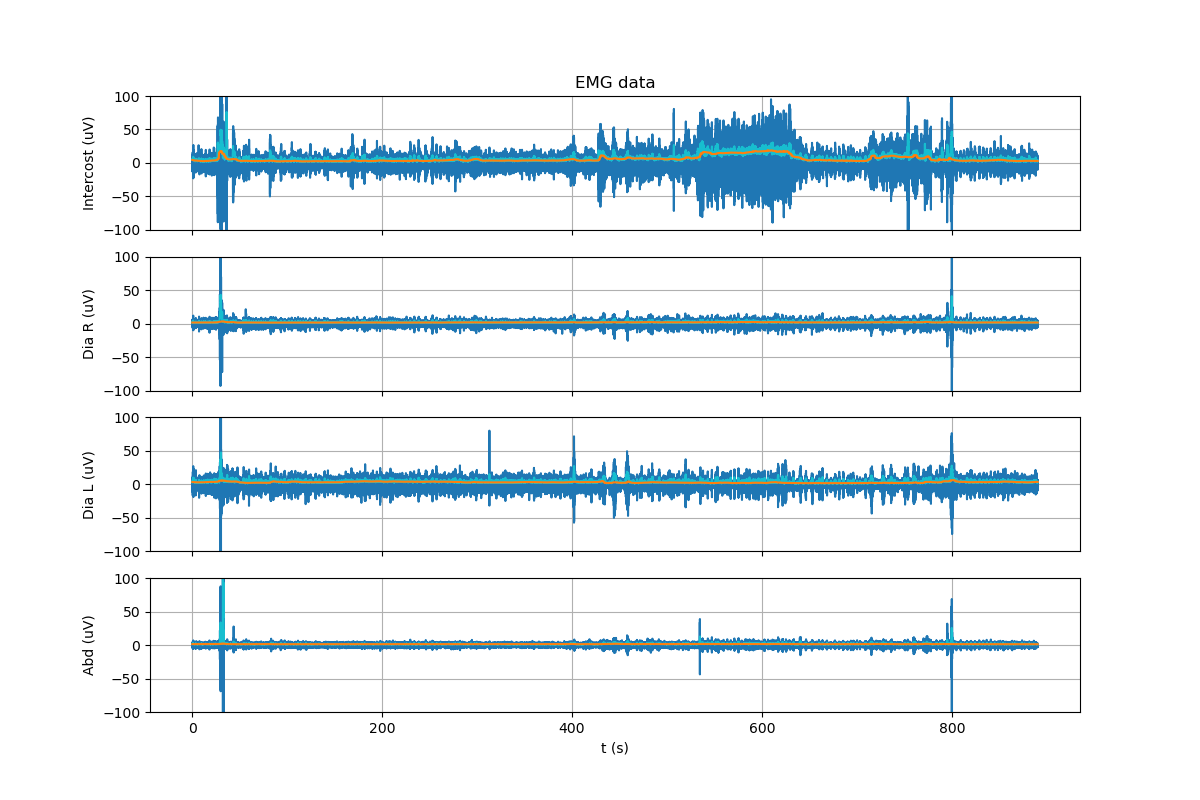

In [11]:
# Plot the raw data with the envelope
n_ch=4
fig, axis = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch/3*6), sharex=True)
axes_emg = axis[:n_ch]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run('plot_full',
    axes=axes_emg, signal_type='clean', baseline_bool=False)

emg_timeseries.run('plot_full',axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')
for ax in axes_emg:
    ax.set_ylim(-100, 100)

# 3. Identify all sEMG breaths

In [12]:
# Find sEAdi peaks
intercost = emg_timeseries.channels[0]
intercost.detect_emg_breaths(peak_set_name='breaths')
intercost.peaks['breaths'].detect_on_offset(
    baseline=intercost.y_baseline)

emg_di_r = emg_timeseries.channels[1]
emg_di_r.detect_emg_breaths(peak_set_name='breaths')
emg_di_r.peaks['breaths'].detect_on_offset(
    baseline=emg_di_r.y_baseline
)
emg_di_l = emg_timeseries.channels[2]
emg_di_l.detect_emg_breaths(peak_set_name='breaths')
emg_di_l.peaks['breaths'].detect_on_offset(
    baseline=emg_di_l.y_baseline
)

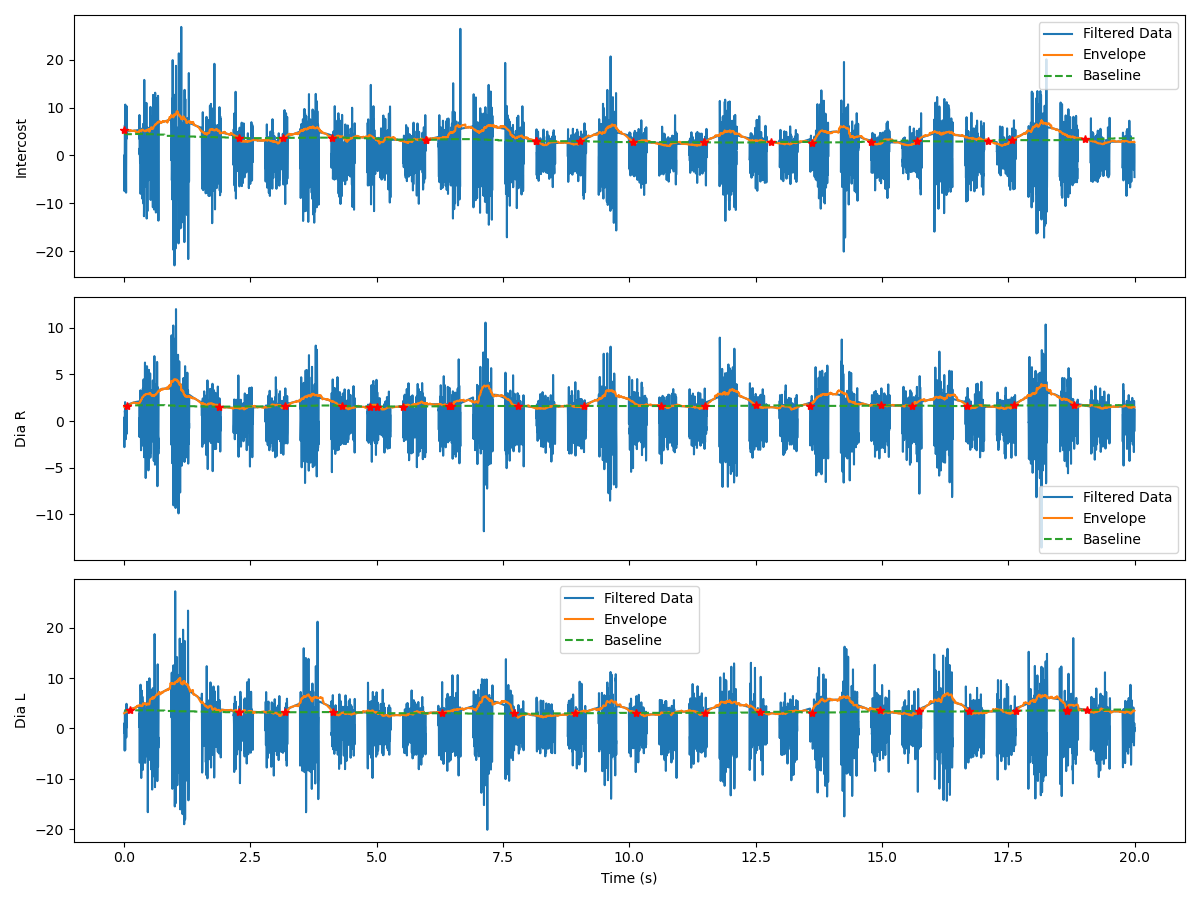

In [13]:
# Define the time range for the first 20 seconds
time_range = 20  # seconds
end_idx = int(time_range * fs_emg)
n_ch=3
# Create a figure with subplots for each channel
fig, axes = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch * 3), sharex=True)

# Plot each channel
for i in range(n_ch):
    # Extract the segments of the signals
    filtered_segment = emg_timeseries.channels[i].y_clean[:end_idx]
    envelope_segment = emg_timeseries.channels[i].y_env[:end_idx]
    baseline_segment = emg_timeseries.channels[i].y_baseline[:end_idx]
    time_segment = emg_timeseries.channels[i].t_data[:end_idx]

    # Plot the segments
    axes[i].plot(time_segment, filtered_segment, label='Filtered Data', linestyle='-')
    axes[i].plot(time_segment, envelope_segment, label='Envelope', linestyle='-')
    axes[i].plot(time_segment, baseline_segment, label='Baseline', linestyle='--')

    # Plot the markers manually with red asterisks
    for peak in emg_timeseries.channels[i].peaks['breaths'].peak_df.itertuples():
        if peak.start_idx < end_idx:
            axes[i].plot(emg_timeseries.channels[i].t_data[peak.start_idx], emg_timeseries.channels[i].y_env[peak.start_idx], 'r*')  # Start marker
        if peak.end_idx < end_idx:
            axes[i].plot(emg_timeseries.channels[i].t_data[peak.end_idx], emg_timeseries.channels[i].y_env[peak.end_idx], 'r*')      # End marker

    # Add titles and labels
    axes[i].set_ylabel(emg_timeseries.channels[i].label)
    axes[i].legend()

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

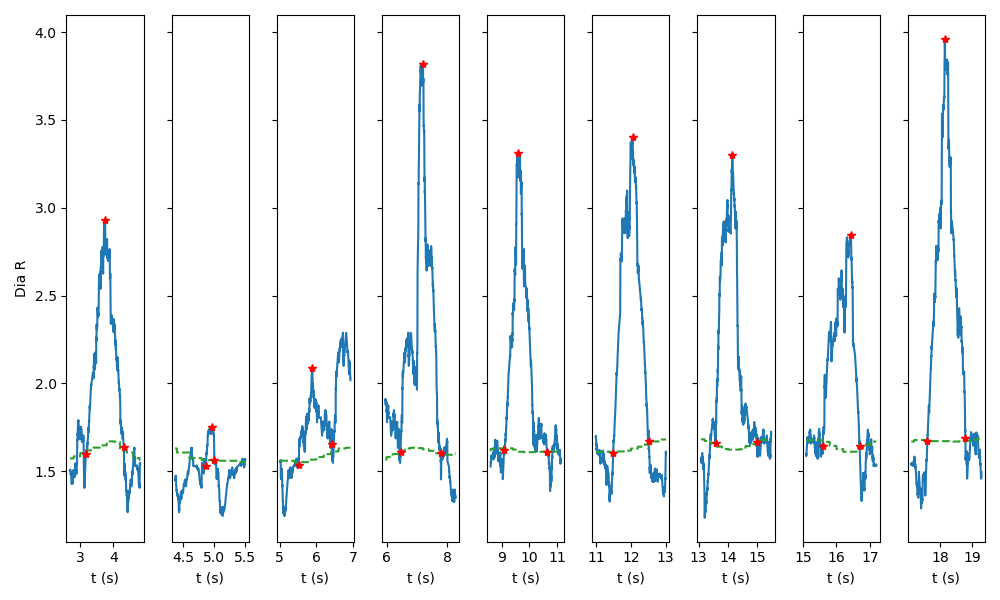

In [14]:
# Select the peaks to plot
peak_df = emg_di_r.peaks['breaths'].peak_df.iloc[1:10]

# Define the number of samples to plot before and after the peak
margin_samples = fs_emg // 2  # Half a second before and after

# Plot the selected peaks for sEAdi
n_peaks = len(peak_df)
fig, axis = plt.subplots(nrows=1, ncols=n_peaks, figsize=(10, 6), sharey='row')

# Ensure axes_emg is always a list of axes
if n_peaks == 1:
    axes_emg = [axis]
else:
    axes_emg = axis[:]

colors = ['tab:cyan', 'tab:orange', 'tab:red']

# Plot each selected peak individually
for i, row in enumerate(peak_df.itertuples()):
    start_idx = max(row.start_idx - margin_samples, 0)
    end_idx = min(row.end_idx + margin_samples, len(emg_di_r.y_env))

    # Extract the segment of the signal corresponding to the peak
    segment = emg_di_r.y_env[start_idx:end_idx]
    time = emg_di_r.t_data[start_idx:end_idx]

    # Plot the segment
    axes_emg[i].plot(time, segment, color='tab:blue')

    # Plot the baseline
    baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
    axes_emg[i].plot(time, baseline_segment, color='tab:green', linestyle='--')

    # Plot the markers manually with red asterisks
    axes_emg[i].plot(emg_di_r.t_data[row.start_idx], emg_di_r.y_env[row.start_idx], 'r*')  # Start marker
    axes_emg[i].plot(emg_di_r.t_data[row.end_idx], emg_di_r.y_env[row.end_idx], 'r*')      # End marker
    peak_idx = row.peak_idx
    axes_emg[i].plot(emg_di_r.t_data[peak_idx], emg_di_r.y_env[peak_idx], 'r*')           # Peak marker

# Set labels
axes_emg[0].set_ylabel(emg_di_r.label)
for ax in axes_emg:
    ax.set_xlabel('t (s)')

plt.tight_layout()
plt.show()


# 5. Calculate features

In [15]:
# Respiratory rate

emg_di_idxs = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_di_r, _ = feat.respiratory_rate(emg_di_idxs, fs_emg)

emg_di_idxs = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_di_l, _ = feat.respiratory_rate(emg_di_idxs, fs_emg)

emg_di_idxs = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_intercost, _ = feat.respiratory_rate(emg_di_idxs, fs_emg)

print(rr_di_r)
print(rr_di_l)
print(rr_intercost)

30.737737186048342
28.790813464816907
29.747156543489545


In [16]:
# Get the indices of all detected breaths
breath_peak_idxs_di_r = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_di_l = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_intercost = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()

# Calculate the amplitude of all detected breaths
sEAdi_amplitudes_dia_r = feat.amplitude(
    signal=emg_di_r.y_env,
    peak_idxs=breath_peak_idxs,
    baseline=emg_di_r.y_baseline,
)

NameError: name 'breath_peak_idxs' is not defined

In [80]:
# Calculate the area under the curve (AUC) for all detected breaths
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')

# Store the AUC values in a variable
sEAdi_auc_di_r = emg_di_r.peaks['breaths'].peak_df['AUC'].to_numpy()



In [81]:
print(emg_di_r.peaks['breaths'].peak_df.columns)


Index(['peak_idx', 'start_idx', 'end_idx', 'valid', 'AUB', 'aub_y_ref', 'AUC'], dtype='object')


# 6. Test sEMG quality

In [82]:
# Test EMG quality
parameter_names = {
    'time_product': 'AUC'
}
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


In [83]:
quality_outcomes_df = emg_di_r.peaks['breaths'].quality_outcomes_df

# Count the number of False values in each specified column
columns_to_check = ['baseline_detection', 'interpeak_distance', 'snr', 'aub', 'bell']
false_counts = quality_outcomes_df[columns_to_check].apply(lambda col: (col == False).sum())

# Print the results
print(false_counts)

baseline_detection     2
interpeak_distance     0
snr                    0
aub                   31
bell                   3
dtype: int64


In [84]:
print(emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[1])


peak_idx               1400
baseline_detection    False
interpeak_distance     True
snr                    True
aub                    True
bell                  False
relative_aub           True
relative_etp           True
Name: 1, dtype: object


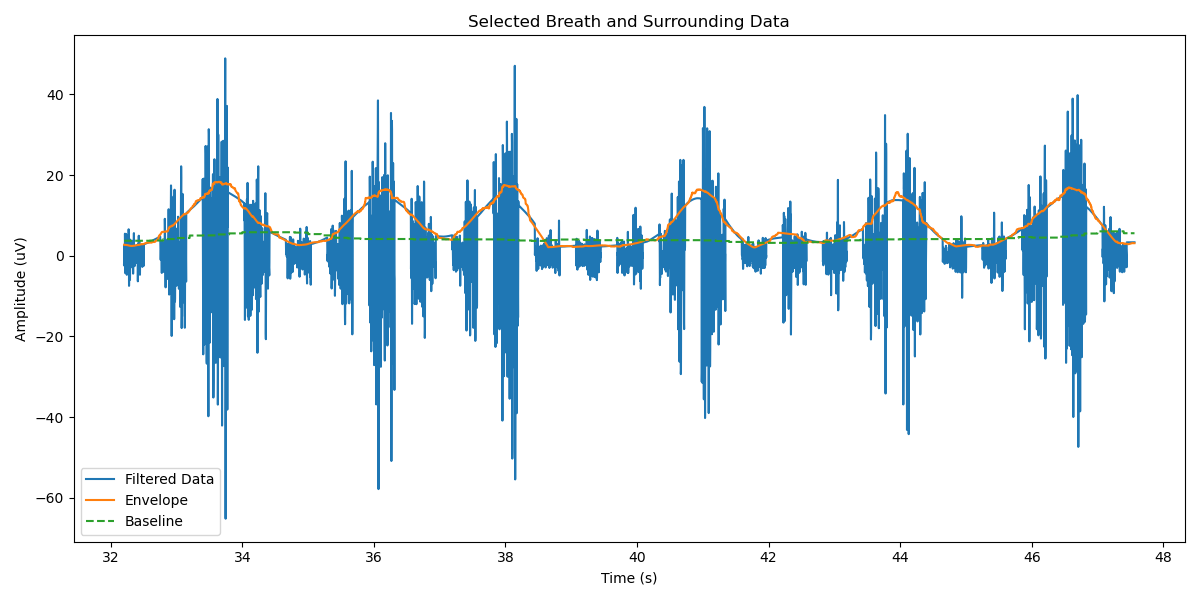

In [85]:
import matplotlib.pyplot as plt

# Define the breath number you want to plot
breath_number = 14  # Change this to the desired breath number

# Ensure the breath number is within the valid range
if breath_number < 1 or breath_number > len(emg_di_r.peaks['breaths'].quality_outcomes_df) - 2:
    raise ValueError("Breath number out of range. Please choose a number between 1 and {}.".format(len(emg_di_r.peaks['breaths'].quality_outcomes_df) - 2))

# Get the indices of the breaths to plot
start_idx = emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[breath_number]['peak_idx']-2000
end_idx = emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[breath_number + 4]['peak_idx']+500
# Extract the segments of the signals
filtered_segment = emg_di_r.y_clean[start_idx:end_idx]
envelope_segment = emg_di_r.y_env[start_idx:end_idx]
baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
time_segment = emg_di_r.t_data[start_idx:end_idx]

# Plot the segments
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_segment, filtered_segment, label='Filtered Data', linestyle='-')
ax.plot(time_segment, envelope_segment, label='Envelope', linestyle='-')
ax.plot(time_segment, baseline_segment, label='Baseline', linestyle='--')

# Add titles and labels
ax.set_title('Selected Breath and Surrounding Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (uV)')
ax.legend()

plt.tight_layout()
plt.show()


In [86]:
#print(emg_di_r.peaks['breaths'].quality_outcomes_df)

# Print all lines that have a False value in any of the specified columns
false_rows = quality_outcomes_df[columns_to_check].apply(lambda row: row == False, axis=1)
print(quality_outcomes_df[false_rows.any(axis=1)])

     peak_idx  baseline_detection  interpeak_distance   snr    aub   bell  \
1        1400               False                True  True   True  False   
4        5045                True                True  True  False   True   
5        5825                True                True  True  False   True   
6        7030                True                True  True  False   True   
21      26043                True                True  True  False   True   
40      52911                True                True  True  False   True   
41      54455                True                True  True  False   True   
42      55794                True                True  True  False   True   
43      57268                True                True  True  False   True   
44      58689                True                True  True  False   True   
46      61725                True                True  True  False   True   
47      63176                True                True  True  False   True   

In [87]:
# The peak-validity is updated in the peak_df:
print(emg_di_r.peaks['breaths'].peak_df)

     peak_idx  start_idx  end_idx  valid        AUB  aub_y_ref        AUC  \
0         828        295     1739   True   5.405756   2.403675  20.930596   
1        1400        295     1739  False   5.405756   2.403675  20.930596   
2        2639       2345     2945   True   1.401381   2.912125   7.320921   
3        3926       3538     4273   True   2.092191   2.981908  10.383454   
4        5045       4730     5299  False   4.591145   2.981908  10.672220   
..        ...        ...      ...    ...        ...        ...        ...   
111    146949     146400   147309   True   3.457707   2.982044  13.506321   
112    148222     147830   148541   True   3.179222   3.351641   9.830470   
113    149474     148900   149777  False   5.621022   3.351641  11.231698   
114    150811     150072   151070  False  10.117552   1.996488  15.450379   
115    152042     151572   152397  False   7.610208   1.996488  12.961649   

     bell_y_min     bell_a      bell_b    bell_c  
0      2.403675   8.6336

C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_25324\907712053.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


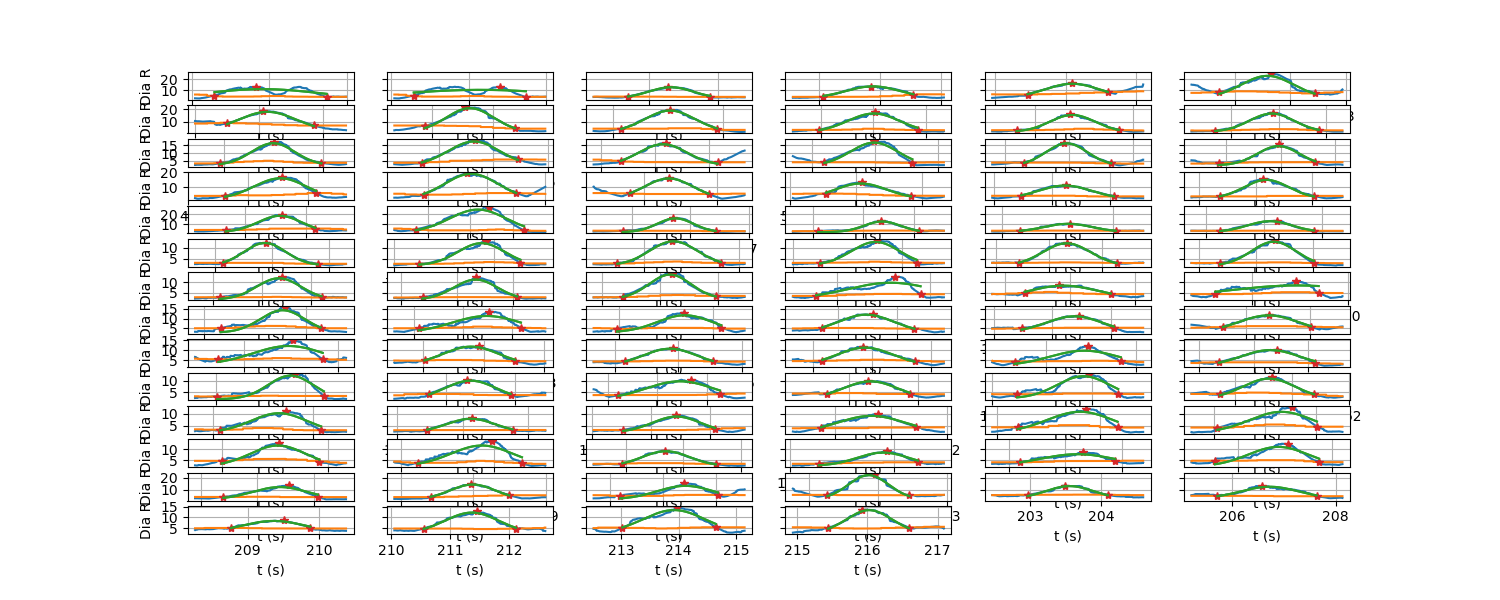

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to include only valid peaks
valid_peaks_df = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]

# Get the number of valid peaks
n_peaks = len(valid_peaks_df['start_idx'].to_numpy())

# Define the maximum number of columns
max_cols = 6

# Calculate the number of rows needed
n_rows = int(np.ceil(n_peaks / max_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=max_cols, figsize=(15, 6), sharey='row')

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Ensure axes_emg is always a list of axes
axes_emg = axes_flat[:n_peaks]

colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di_r.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_markers(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_curve_fits(axes=axes_emg, peak_set_name='breaths')

# Set labels for the first column and all axes
for i, axis in enumerate(axes_emg):
    if i % max_cols == 0:
        axis.set_ylabel(emg_di_r.label)
    axis.set_xlabel('t (s)')

# Hide any unused subplots
for j in range(n_peaks, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()


In [89]:
# Calculate the number of breaths in valid peaks
num_valid_breaths = len(valid_peaks_df)

print(f"The number of breaths in valid peaks is {num_valid_breaths}.")

mean_auc = valid_peaks_df['AUC'].mean()
print(f"The mean value of the attribute 'auc' for the valid breaths is {mean_auc}.")
# Calculate the median value of the attribute 'aub' for the valid breaths
median_auc = valid_peaks_df['AUC'].median()

print(f"The median value of the attribute 'auc' for the valid breaths is {median_auc}.")
# Calculate the standard deviation of the attribute 'aub' for the valid breaths
std_auc = valid_peaks_df['AUC'].std()

print(f"The standard deviation of the attribute 'auc' for the valid breaths is {std_auc}.")



The number of breaths in valid peaks is 82.
The mean value of the attribute 'auc' for the valid breaths is 11.688794514628507.
The median value of the attribute 'auc' for the valid breaths is 11.036013937488152.
The standard deviation of the attribute 'auc' for the valid breaths is 4.1189381959131754.


In [46]:
# Detect local high baselines in EMGdi
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUB')
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


emg_di_aubs = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_aubs = qa.detect_local_high_aub(
    aubs=emg_di_aubs,
    threshold_percentile=75,
    threshold_factor=4,
)
valid_aubs


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [47]:
ETPdi_r_list = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_etps = qa.detect_extreme_time_products(
    ETPdi_r_list,
    upper_percentile=95.0,
    upper_factor=10.0,
    lower_percentile=5.0,
    lower_factor=.1,
)
valid_etps


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [31]:
print(len(emg_di_r.peaks['breaths']))

348
